In [1]:
import os
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images
!unzip chest-ctscan-images.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
License(s): ODbL-1.0
  0% 0.00/119M [00:00<?, ?B/s]
100% 119M/119M [00:00<00:00, 1.70GB/s]
Archive:  chest-ctscan-images.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  


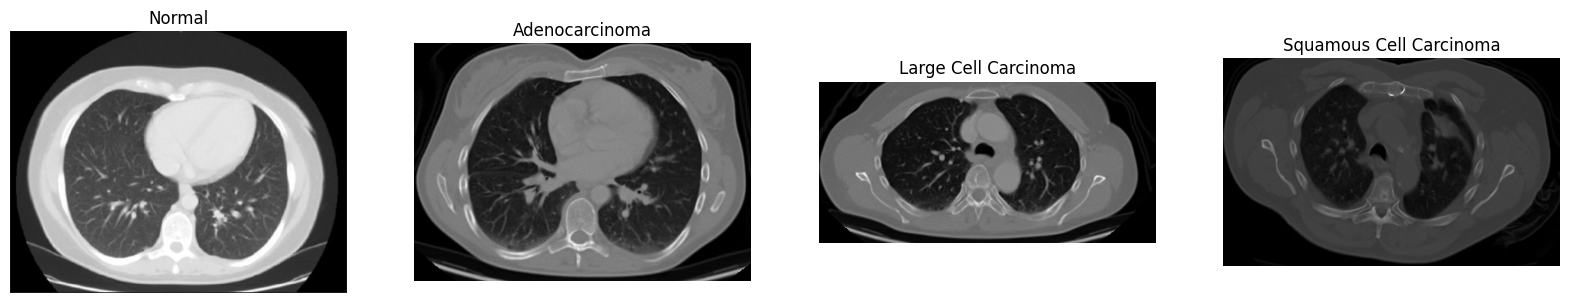

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# directories
normal_image_dir = '/content/Data/train/normal/'
adenocarcinoma_image_dir = '/content/Data/train/adenocarcinoma/'
large_cell_carcinoma_image_dir = '/content/Data/train/large cell carcinoma/'
squamous_cell_carcinoma_image_dir = '/content/Data/train/squamous cell carcinoma/'

# get all images
normal_images = os.listdir(normal_image_dir)
adenocarcinoma_images = os.listdir(adenocarcinoma_image_dir)
large_cell_carcinoma_images = os.listdir(large_cell_carcinoma_image_dir)
squamous_cell_carcinoma_images = os.listdir(squamous_cell_carcinoma_image_dir)

# load samples
normal_image_path = os.path.join(normal_image_dir, normal_images[0])
adenocarcinoma_image_path = os.path.join(adenocarcinoma_image_dir, adenocarcinoma_images[0])
large_cell_carcinoma_image_path = os.path.join(large_cell_carcinoma_image_dir, large_cell_carcinoma_images[0])
squamous_cell_carcinoma_image_path = os.path.join(squamous_cell_carcinoma_image_dir, squamous_cell_carcinoma_images[0])

normal_image = Image.open(normal_image_path).convert('RGB')
adenocarcinoma_image = Image.open(adenocarcinoma_image_path).convert('RGB')
large_cell_carcinoma_image = Image.open(large_cell_carcinoma_image_path).convert('RGB')
squamous_cell_carcinoma_image = Image.open(squamous_cell_carcinoma_image_path).convert('RGB')

# plot samples
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(normal_image)
axes[0].set_title('Normal')
axes[0].axis('off')

axes[1].imshow(adenocarcinoma_image)
axes[1].set_title('Adenocarcinoma')
axes[1].axis('off')

axes[2].imshow(large_cell_carcinoma_image)
axes[2].set_title('Large Cell Carcinoma')
axes[2].axis('off')

axes[3].imshow(squamous_cell_carcinoma_image)
axes[3].set_title('Squamous Cell Carcinoma')
axes[3].axis('off')

plt.show()

In [4]:
!find /content/Data/ -type d -name ".ipynb_checkpoints" -exec rm -rf {} +

In [5]:
from torchvision import datasets

train_dir = '/content/Data/train/'
test_dir = '/content/Data/test/'
val_dir = '/content/Data/valid/'

train_data = datasets.ImageFolder(root=train_dir)
test_data = datasets.ImageFolder(root=test_dir)
val_data = datasets.ImageFolder(root=val_dir)

class_names = train_data.classes

def count_classes(dataset):
    counts = [0] * len(dataset.classes)
    for _, label in dataset:
        counts[label] += 1
    return counts

# Hitung per set
train_counts = count_classes(train_data)
test_counts = count_classes(test_data)
val_counts = count_classes(val_data)

print("TRAIN SET")
for cls, count in zip(class_names, train_counts):
    print(f"- {cls}: {count}")

print("\nTEST SET")
for cls, count in zip(class_names, test_counts):
    print(f"- {cls}: {count}")

print("\nVALIDATION SET")
for cls, count in zip(class_names, val_counts):
    print(f"- {cls}: {count}")

TRAIN SET
- adenocarcinoma: 195
- large cell carcinoma: 115
- normal: 148
- squamous cell carcinoma: 155

TEST SET
- adenocarcinoma: 120
- large cell carcinoma: 51
- normal: 54
- squamous cell carcinoma: 90

VALIDATION SET
- adenocarcinoma: 23
- large cell carcinoma: 21
- normal: 13
- squamous cell carcinoma: 15


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define augmentations
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# load data with augmentation
train_dir = './Data/train/'
valid_dir = './Data/valid/'
test_dir  = './Data/test/'

train_data = datasets.ImageFolder(root=train_dir, transform=augmentation_transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=base_transform)
test_data  = datasets.ImageFolder(root=test_dir,  transform=base_transform)

# apply class weights
labels = [label for _, label in train_data.samples]

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(weights, dtype=torch.float).to(device)

print("Class Weights:", class_weights)

# data loader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, pin_memory=True)

Class Weights: tensor([0.7859, 1.3326, 1.0355, 0.9887], device='cuda:0')


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_large

# define model
model = mobilenet_v3_large(weights='DEFAULT').to(device)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 4).to(device)

# loss, optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# train loop
num_epochs = 30

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()

    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(valid_loader)
    epoch_val_acc = 100 * correct / total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
    print(f"  Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.2f}%\n")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 195MB/s]


Epoch [1/30]
  Train Loss: 1.1574 | Train Acc: 49.92%
  Val Loss:   1.1816 | Val Acc:   52.78%

Epoch [2/30]
  Train Loss: 0.7953 | Train Acc: 74.23%
  Val Loss:   1.0203 | Val Acc:   38.89%

Epoch [3/30]
  Train Loss: 0.5453 | Train Acc: 79.12%
  Val Loss:   1.0012 | Val Acc:   52.78%

Epoch [4/30]
  Train Loss: 0.3614 | Train Acc: 87.93%
  Val Loss:   1.0277 | Val Acc:   43.06%

Epoch [5/30]
  Train Loss: 0.2121 | Train Acc: 94.78%
  Val Loss:   0.9398 | Val Acc:   43.06%

Epoch [6/30]
  Train Loss: 0.1187 | Train Acc: 96.41%
  Val Loss:   0.8727 | Val Acc:   61.11%

Epoch [7/30]
  Train Loss: 0.1129 | Train Acc: 96.41%
  Val Loss:   0.8655 | Val Acc:   55.56%

Epoch [8/30]
  Train Loss: 0.0775 | Train Acc: 97.23%
  Val Loss:   0.8825 | Val Acc:   51.39%

Epoch [9/30]
  Train Loss: 0.0439 | Train Acc: 99.02%
  Val Loss:   0.9336 | Val Acc:   51.39%

Epoch [10/30]
  Train Loss: 0.0387 | Train Acc: 99.02%
  Val Loss:   0.7967 | Val Acc:   56.94%

Epoch [11/30]
  Train Loss: 0.0761 | Tr

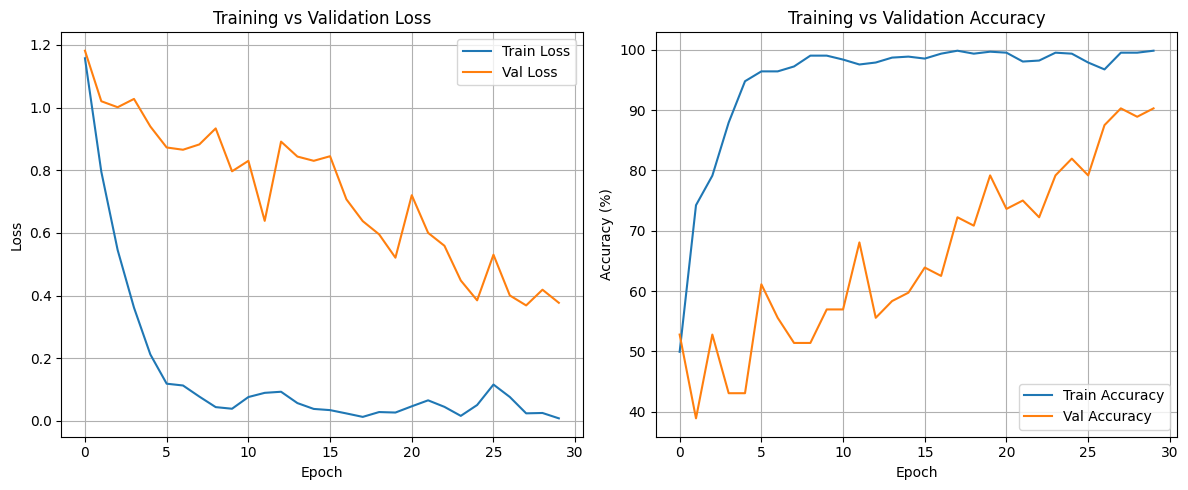

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn.functional as F

model.eval()
all_labels = []
all_preds = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 79.37%


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
conf_matrix = confusion_matrix(all_labels, all_preds)

class_names = test_data.classes

print(f"\nOverall Accuracy: {accuracy*100:.2f}%")
print(f"Macro F1 Score: {macro_f1:.4f}\n")

print("Metrics per Class:")
for i, cls in enumerate(class_names):
    print(f"{cls}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)


Overall Accuracy: 79.37%
Macro F1 Score: 0.8111

Metrics per Class:
adenocarcinoma:
  Precision: 0.9250
  Recall:    0.6167
  F1 Score:  0.7400
large cell carcinoma:
  Precision: 0.5604
  Recall:    1.0000
  F1 Score:  0.7183
normal:
  Precision: 1.0000
  Recall:    0.9815
  F1 Score:  0.9907
squamous cell carcinoma:
  Precision: 0.7912
  Recall:    0.8000
  F1 Score:  0.7956

Confusion Matrix:
[[74 27  0 19]
 [ 0 51  0  0]
 [ 0  1 53  0]
 [ 6 12  0 72]]


In [11]:
torch.save(model.state_dict(), 'CTScan_MobileNetV3Large.pth')
print('Model saved')

Model saved
